This code performs four main tasks:

**[First part]**
- annotate the MitImpact's variants with additional information provided by supplementary files available in the `data/APOGEE2_2022` folder. 
- select the features of interest that will later be used in the learning process and store them in a file named `mitimpact_features.csv` stored in a newly created `extracted_data` folder.

**[Seconda part]**
- perform a nested cross-validation. You will be given the chance to choose the machine learning classifier among a few alternatives, the number of splits and partitions for the test cross-validation, the number of splits for the grid-search cross-validation.
- calculate a few performance measures.

Note that several hours are required to execute the entire notebook and that some of the hyperparameters have been dropped from the grid-search procedure in order to speed up the computation. The notebook will create a `test/` folder to store models and predictions (if `test/` is not empty its content will be overwritten). After completing the cross-validation procedure, the notebook will calculate the mean auROC and its confidence intervals.

In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import os, warnings

from matplotlib import pyplot as plt
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.base import clone

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectFromModel

from imblearn.pipeline import Pipeline

In [3]:
# Download data from github and set the current working folder
if not os.path.exists("./playgrounds/data/APOGEE2_2022/") and not os.path.exists("./data/APOGEE2_2022/"):
    !git clone https://github.com/mazzalab/playgrounds.git
else:
    print("Package in place")

PATH="."

Package in place


# First part

#### Retrieve and prepare the MitImpact database flat file

In [13]:
mitimpact = pd.read_csv(PATH+"/data/APOGEE2_2022/MitImpact_db_3.0.6.1.txt", sep="\t", low_memory=False, index_col="MitImpact_id")

# Rename the column Start to Pos
mitimpact.rename(columns={"Start": "Pos"}, inplace=True)

# Replace "." with NaN values
mitimpact.replace(".", np.nan, inplace=True)

mitimpact.head()

,Chr,Pos,End,Ref,Alt,Gene_symbol,Respiratory_Chain_complex,Ensembl_gene_id,Ensembl_protein_id,Ensembl_transcript_id,...,DDG_intra,DDG_intra_interface,DDG_inter,CPD_Frequency,CPD_AA_ref,CPD_AA_alt,CPD_Aln_pos,CPD_RefSeq_protein_id,CPD_Species_name,CPD_Ncbi_taxon_id
MitImpact_id,,,,,,,,,,,,,,,,,,,,,
MI.1,chrM,8527,8527,A,C,MT-ATP6,V,ENSG00000198899,ENSP00000354632,ENST00000361899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI.24190,chrM,8527,8527,A,G,MT-ATP6,V,ENSG00000198899,ENSP00000354632,ENST00000361899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI.10,chrM,8531,8531,A,T,MT-ATP6,V,ENSG00000198899,ENSP00000354632,ENST00000361899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI.100,chrM,8572,8572,G,A,MT-ATP6,V,ENSG00000198899,ENSP00000354632,ENST00000361899,...,MT-ATP6:G16S:L17V:0.397938:-0.825033:1.10339;M...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI.1000,chrM,8995,8995,G,A,MT-ATP6,V,ENSG00000198899,ENSP00000354632,ENST00000361899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Read the mitochondrial substitution matrix (mtMam)

In [5]:
mtmam = pd.read_csv(PATH+"/data/APOGEE2_2022/mtmam.csv", sep="\t",  index_col=0)
mtmam.head()

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0,32,2,11,0,0,0,78,8,75,21,0,76,0,53,342,681,5,0,398
R,32,0,4,0,186,246,0,18,232,0,6,50,0,0,9,3,0,16,0,0
N,2,4,0,864,0,8,0,47,458,19,0,408,21,6,33,446,110,6,156,0
D,11,0,864,0,0,49,569,79,11,0,0,0,0,5,2,16,0,0,0,10
C,0,186,0,0,0,0,0,0,305,41,27,0,0,7,0,347,114,65,530,0


In [6]:
# Annotate the mitimpact variants with mtMam scores
mitimpact["mtmam"] = mtmam.stack().loc[mitimpact.set_index(["AA_ref", "AA_alt"]).index].to_numpy()
mitimpact[["mtmam"]].head()

,mtmam
MitImpact_id,
MI.1,609
MI.24190,832
MI.10,19
MI.100,112
MI.1000,681


#### Load, format, and integrate the precomputed energetic variation values, calculated as $\Delta \Delta G = \Delta G_{mutant} - \Delta G_{wt}$,  into MitImpact 

In [8]:
ddg = pd.DataFrame.from_dict(pk.load(open(PATH+"/data/APOGEE2_2022/ddg_dict.pk", "rb")), orient="index").stack().to_frame()

# Parse the dataframe
ddg = pd.DataFrame(ddg[0].values.tolist(), index=ddg.index).stack().to_frame()

# Rename the column of the scores as "ddg"
ddg.columns = ["ddg"]

# Reset index
ddg.reset_index(inplace=True)

# Parse the information about the position of AA in the protein
ddg["AA_pos"] = ddg.level_1.str.split(r"[A-Z]", expand=True)[1].astype(float)

# Parse the information about the reference AA
ddg["level_1"] = ddg.level_1.str.split("", expand=True)[1]

# Rename the columns
ddg.rename(columns={"level_0":"Gene_symbol","level_2":"AA_alt","level_1":"AA_ref"}, inplace=True)

# Annotate variants in MitImpact with the ddg values (from the `ddg` dataframe)
mitimpact["ddg"] = pd.merge(
    mitimpact[["Gene_symbol","AA_pos","AA_ref","AA_alt"]],
    ddg,
    on=["Gene_symbol","AA_pos","AA_ref","AA_alt"],
    how="left",
).ddg.to_numpy()

mitimpact[["ddg"]].head()

,ddg
MitImpact_id,
MI.1,0.051975
MI.24190,0.143306
MI.10,0.489689
MI.100,2.599890
MI.1000,2.706880


#### Read the 3D coordinates of the amino acids

In [11]:

coords3D = pd.read_csv(PATH+"/data/APOGEE2_2022/AA3Dposition_aligned.csv", sep="\t", header=None)

# Rename the columns appropriately
coords3D.columns=["Gene_symbol", "AA_pos", "X", "Y", "Z"]

# Annotate the variants in MitImpact with X, Y, and Z values corresponding to the 3D coordinates of the amino acids.
mitimpact[["X", "Y", "Z"]] = pd.merge(
    mitimpact[["Gene_symbol","AA_pos"]],
    coords3D,
    on=["Gene_symbol","AA_pos"],
    how="left",
)[["X", "Y", "Z"]].to_numpy()

mitimpact[["X", "Y", "Z"]].head()

,X,Y,Z
MitImpact_id,,,
MI.1,333.852875,252.987000,326.60625
MI.24190,333.852875,252.987000,326.60625
MI.10,331.590750,254.633625,331.60725
MI.100,308.031750,264.556750,329.66025
MI.1000,310.985400,244.466200,347.55800


#### Create of a list containing the names of features to extract from the `mitimpact` dataframe

In [12]:
features = [
    "PhyloP_100V", "PhastCons_100V", "PolyPhen2_score", "SIFT_score", "FatHmmW_score",
    "FatHmm_score", "PROVEAN_score", "MutationAssessor_score", "EFIN_SP_score", "EFIN_HD_score",
    "CADD_phred_score", "VEST_pvalue", "PANTHER_score", "PhD-SNP_score", "SNAP_score", "MutationTaster_score",
    "mtmam", "ddg", "Pos",  "X", "Y", "Z"
]

# Cast the variables into float values.
mitimpact[features] = mitimpact[features].astype(float)

# Save the dataframe obtained.
try:
  os.mkdir(PATH+"/data/APOGEE2_2022/extracted_data/")
except FileExistsError:
  print("The folder exists. Data will be overwritten")
  
mitimpact[features].to_csv(PATH+"/data/APOGEE2_2022/extracted_data/mitimpact_features.csv", sep="\t")
mitimpact[features].head()

The folder exists. Data will be overwritten


,PhyloP_100V,PhastCons_100V,PolyPhen2_score,SIFT_score,FatHmmW_score,FatHmm_score,PROVEAN_score,MutationAssessor_score,EFIN_SP_score,EFIN_HD_score,...,PANTHER_score,PhD-SNP_score,SNAP_score,MutationTaster_score,mtmam,ddg,Pos,X,Y,Z
MitImpact_id,,,,,,,,,,,,,,,,,,,,,
MI.1,2.21,1.0,0.52,0.02,4.70,0.88,-2.48,NaN,0.63,0.08,...,0.68,0.34,0.63,NaN,609.0,0.051975,8527.0,333.852875,252.987000,326.60625
MI.24190,2.21,1.0,0.79,0.01,4.73,0.27,-3.30,NaN,0.71,0.12,...,0.43,0.36,0.41,NaN,832.0,0.143306,8527.0,333.852875,252.987000,326.60625
MI.10,6.84,1.0,0.99,0.57,4.65,-0.66,-4.59,1.40,0.86,0.52,...,0.32,0.53,0.27,1.00,19.0,0.489689,8531.0,331.590750,254.633625,331.60725
MI.100,0.13,0.8,0.56,0.17,4.67,0.05,-4.62,2.23,0.96,0.43,...,0.52,0.80,0.44,1.00,112.0,2.599890,8572.0,308.031750,264.556750,329.66025
MI.1000,-1.26,0.0,1.00,0.30,3.70,-1.55,-2.93,1.34,0.77,0.51,...,0.43,0.73,0.58,0.94,681.0,2.706880,8995.0,310.985400,244.466200,347.55800


# Second part

##### Handy functions and files check

In [35]:
import shutil

def _empty_or_create(folder_path):
  if(os.path.exists(folder_path)):
    warnings.warn(folder_path+" is not empty. It will be emptied")
    shutil.rmtree(folder_path)
  
  os.mkdir(folder_path)

In [21]:
# Existence file check
if not 'dataset_21-04-21.csv' in os.listdir(PATH+"/data/APOGEE2_2022/"):
  raise FileNotFoundError(f"Cannot find 'dataset_21-04-21.csv' in folder {PATH}/data/APOGEE2_2022/")
elif not 'mitimpact_features.csv' in os.listdir(PATH+"/data/APOGEE2_2022/extracted_data"):
  raise FileNotFoundError(f"Cannot find 'mitimpact_features.csv' in folder {PATH}/data/APOGEE2_2022/. Please ensure you have executed the first part of the code above")
else:
    print("Required files present")

Required files present


Read the classes of training-set variants:
- `0` means Benign variants;
- `1` means Pathogenic variants.

The index values are the `MitImpact_ID` of the variants.

In [20]:
Y = pd.read_csv(PATH+"/data/APOGEE2_2022/dataset_21-04-21.csv", sep="\t", index_col="MitImpact_ID", comment="#").Class
Y.replace(["N", "P"], [0, 1], inplace=True)

# Target Vector
Y.head()

MitImpact_ID
MI.10759    0
MI.10766    0
MI.10778    0
MI.10783    0
MI.10796    0
Name: Class, dtype: int64

Annotate the training-set variants (`Y` vector) with the features extracted from the `mitimpact_features.csv` file (previously generated in the **First part**)


In [23]:
X = pd.read_csv(PATH+"/data/APOGEE2_2022/extracted_data/mitimpact_features.csv", sep="\t", index_col="MitImpact_id").loc[Y.index]

# Feature Matrix
X.head()

,PhyloP_100V,PhastCons_100V,PolyPhen2_score,SIFT_score,FatHmmW_score,FatHmm_score,PROVEAN_score,MutationAssessor_score,EFIN_SP_score,EFIN_HD_score,...,PANTHER_score,PhD-SNP_score,SNAP_score,MutationTaster_score,mtmam,ddg,Pos,X,Y,Z
MitImpact_ID,,,,,,,,,,,,,,,,,,,,,
MI.10759,3.67,0.98,0.99,0.00,2.81,-0.08,-1.86,NaN,0.52,0.15,...,NaN,0.43,0.54,NaN,59.0,0.066658,3308.0,585.543125,535.305500,698.262000
MI.10766,-1.85,0.00,0.01,1.00,2.97,2.38,1.03,0.00,0.93,0.75,...,NaN,0.10,0.26,1.0,43.0,-0.143358,3311.0,589.746429,536.957571,698.721714
MI.10778,-0.01,0.00,0.00,0.51,2.86,0.47,2.65,-0.90,0.94,0.96,...,NaN,0.03,0.19,1.0,398.0,0.277332,3317.0,588.026400,533.578400,702.519200
MI.10783,-6.90,0.00,1.00,0.19,2.75,-0.74,-3.93,2.71,0.73,0.47,...,NaN,0.49,0.60,1.0,864.0,0.295670,3319.0,591.614500,532.996875,701.267375
MI.10796,-20.00,0.00,0.33,0.29,2.15,-3.64,-1.33,3.00,0.90,0.71,...,NaN,0.34,0.52,1.0,609.0,-0.984018,3325.0,589.071625,535.268250,707.413125


## ML Settings

In [25]:
#@title ##Settings

#@markdown <h2>**SETTINGS**</h2>

#@markdown


#@markdown choose the machine learning classifier
method = 'KNN_RusSmote' #@param ["BalancedRF", "GNB_BalancedBagging", "KNN_BalancedBagging", "KNN_RusSmote", "rbfSVC", "RusSmoteForest"]

#@markdown

#@markdown select the number of splits for the test cross-validation (outer cv splits)
n_splits = 10 #@param {type:"slider", min:5, max:20, step:1}

#@markdown

#@markdown select the number of different partitions for the test cross-validation (outer cv repetitions)
n_repeats = 2 #@param {type:"slider", min:1, max:10, step:1}

#@markdown <h7>**Attention:**</h7>
#@markdown <h7><i>For computational limit, please ensure that `n_splits * n_repeats` is not greater than 60</i></h7>

#@markdown

#@markdown select the number of splits for the grid-search cross-validation (inner cv splits)
gridsearc_cv_splits = 5 #@param {type:"slider", min:5, max:19, step:1}


#@markdown

#@markdown type an integer number as random state (used for the partitions in both inner and outer cv)
random_state = 118 #@param {type:"integer"}

kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)


#@markdown

#@markdown check if you want to have real-time feedbacks during the training, validation and test (recommended for debugging)
verbose = True #@param {type:"boolean"}

# Define the three sequential preprocessing steps: standardize the features, impute the missing values, remove the low importance features.
preprocessing_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", IterativeImputer(RandomForestRegressor(n_jobs=-1), tol=0.05, verbose=verbose)),
    ("feature_selection", SelectFromModel(DecisionTreeClassifier(criterion="entropy", class_weight="balanced"), threshold=0.01)),
])


# Initialize the classifier according to the settings
# In addition hyper-parameters grid is initialized according to the `method` chosen in the settings
def init_model_and_params():
  global clf, grid

  if method=="rbfSVC":
    from sklearn.svm import SVC
    clf = SVC(class_weight="balanced", kernel='rbf', probability=True)
    grid = ParameterGrid({
        "C": [[100], [10], [1], [0.1]],
        "gamma": [[0.1], [0.01], [0.001], [0.0001]],
    })
    return
  
  if method=="KNN_RusSmote":
    from sklearn.ensemble import BaggingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import SMOTE
    clf = BaggingClassifier(
        base_estimator=Pipeline([
            ("rus", RandomUnderSampler()),
            ("smote", SMOTE(n_jobs=-1)),
            ("clf", KNeighborsClassifier(n_jobs=-1))
        ]),
        n_estimators=200,
        n_jobs=-1,
        verbose=0
    )
    grid = ParameterGrid({
        "base_estimator__clf__n_neighbors": [[3], [5], [7], [9]],
        "base_estimator__rus__sampling_strategy": [[0.25], [0.5]],
        "max_features": [[0.25], [0.5]],
        "base_estimator__clf__weights": [["uniform"], ["distance"]],
    })
    return
  
  if method=="GNB_BalancedBagging":
    
    from imblearn.ensemble import BalancedBaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    clf = BalancedBaggingClassifier(GaussianNB(), n_estimators=200, n_jobs=-1)
    grid = ParameterGrid({
        "base_estimator__var_smoothing": [[1e-07], [1e-08], [1e-09], [1e-10], [1e-11]],
        "max_features": [[0.25], [0.5], [0.75]],
        "max_samples": [[0.25], [0.5], [0.75]],
    })
    return

  if method=="BalancedRF":
    from imblearn.ensemble import BalancedRandomForestClassifier
    clf = BalancedRandomForestClassifier(n_estimators=200, criterion="entropy", n_jobs=-1)
    grid = ParameterGrid({
        "max_depth": [[7], [9], [11], [13]],
        "max_features": [[0.25], [0.5], [0.75]],
        "min_samples_leaf": [[1], [2], [3]],
        "min_samples_split": [[2], [4]],
    })
    return
  
  if method=="RusSmoteForest":
    from sklearn.ensemble import BaggingClassifier
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import SMOTE
    clf = BaggingClassifier(
        base_estimator=Pipeline([
            ("rus", RandomUnderSampler()),
            ("smote", SMOTE(n_jobs=-1)),
            ("clf", DecisionTreeClassifier(criterion="entropy"))
        ]),
        n_estimators=200,
        n_jobs=-1,
        verbose=0
    )
    grid = ParameterGrid({
        "base_estimator__clf__max_depth": [[11], [15], [19]],
        "base_estimator__clf__min_samples_leaf": [[1], [2], [3]],
        "base_estimator__clf__min_samples_split": [[2], [4]],
        "base_estimator__rus__sampling_strategy": [[0.25], [0.5], [0.75]],
        "base_estimator__clf__max_features": [[0.25], [0.5], [0.75]],
        
    })
    return


  if method=="KNN_BalancedBagging":
    from imblearn.ensemble import BalancedBaggingClassifier
    from sklearn.neighbors import KNeighborsClassifier
    clf = BalancedBaggingClassifier(KNeighborsClassifier(), n_estimators=200, n_jobs=-1)
    grid = ParameterGrid({
        "base_estimator__n_neighbors": [[3], [5], [7], [9]],
        "max_features": [[0.25], [0.5], [0.75]],
        "base_estimator__weights": [["distance"]],
        "max_samples": [[0.25], [0.5], [0.75]],
    })
    return
    
  raise ValueError("%s is not a valid method"%method)


init_model_and_params()

# Define the grid-search object according to the classifier and hyper-paramethers grid
gridsearch_clf = GridSearchCV(
    estimator=clf,
    param_grid=grid,
    scoring="roc_auc",
    cv=StratifiedKFold(gridsearc_cv_splits, shuffle=True, random_state=random_state),
    n_jobs=-1,
    error_score="raise",
    verbose=verbose,
)

if n_repeats*n_splits > 60:
  raise ValueError("`n_repeats*n_splits` expected to be <=60, but %s * %s == %s.\nI now rise this `ValueError` in order to avoid a future `IOError`."%(n_repeats, n_splits, n_repeats*n_splits))

In [38]:
#@markdown Folder where data from test will be stored.
TEST_PATH = PATH + "/data/APOGEE2_2022/test" #@param {type:"string"}

For each cross-validation iteration:
1. fit the three sequential preprocessing steps on the training-set;
2. save the fitted preprocessing models.


In [39]:
_empty_or_create(TEST_PATH)
_empty_or_create(TEST_PATH+"/preprocessing/")

for i, (train, test) in enumerate(kf.split(X, Y)):
    preprocessing_pipeline.fit(X.iloc[train], Y[train])
    pk.dump(preprocessing_pipeline, open(TEST_PATH+"/preprocessing/fold_%i.pk"%i, "wb"))

[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Change: 3.6492778877571292, scaled tolerance: 1.1997299960994672 
[IterativeImputer] Change: 2.0251793876224298, scaled tolerance: 1.1997299960994672 
[IterativeImputer] Change: 1.298709343948618, scaled tolerance: 1.1997299960994672 
[IterativeImputer] Change: 1.4391219119403966, scaled tolerance: 1.1997299960994672 
[IterativeImputer] Change: 0.6435890367070565, scaled tolerance: 1.1997299960994672 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Change: 3.193852671051884, scaled tolerance: 1.4675836129370763 
[IterativeImputer] Change: 1.3961001501820145, scaled tolerance: 1.4675836129370763 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Change: 4.004201769862132, scaled tolerance: 1.1981815834894567 
[IterativeImputer] Change: 1.09780768177

The following code:
1. loads the fitted preprocessing steps
2. preprocesses both training and test sets
3. tunes and trains the classifier on the pre-processed training set
4. saves the grid-search (as `GridSearchCV` object) results in the `test/classifier` folder
5. predicts the scores for the pre-processed test set elements
6. saves the predictions in the `test/predictions` folder

In [40]:
def test_on_fold(i, train, test):
  fitted_preprocessing = pk.load(open(TEST_PATH+"/preprocessing/fold_%i.pk"%i, "rb"))
  X_train = fitted_preprocessing.transform(X.iloc[train])
  X_test = fitted_preprocessing.transform(X.iloc[test])
  tuned_classifier = clone(gridsearch_clf).fit(X_train, Y[train])
  pk.dump(tuned_classifier, open(TEST_PATH+"/classifier/fold_%i.pk"%i, "wb"))
  pk.dump(tuned_classifier.predict_proba(X_test)[:,1], open(TEST_PATH+"/predictions/fold_%i.pk"%(i), "wb"))

_empty_or_create(TEST_PATH+"/classifier/")
_empty_or_create(TEST_PATH+"/predictions/")

# For each cross-validation iteration train the classifier as explained in the `test_on_fold` function
for i, (train, test) in enumerate(kf.split(X, Y)):
  print(f"############################## TEST {i} ################################")
  test_on_fold(i, train, test)    

############################## TEST 0 ################################
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Completing matrix with shape (125, 22)
Fitting 5 folds for each of 32 candidates, totalling 160 fits
############################## TEST 1 ################################
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Completing matrix with shape (125, 22)
Fitting 5 folds for each of 32 candidates, totalling 160 fits
############################## TEST 2 ################################
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Completing matrix with shape (125, 22)
Fitting 5 folds for each of 32 candidates, totalling 160 fits
############################## TEST 3 ################################
[IterativeImputer] Completing matrix with shape (1749, 22)
[IterativeImputer] Completing matrix with shape (125, 22)
Fitting 5 folds for each of 32 candidates, totalling 160 fits


#### Compute Area Under the Receiver Operating Characteristic Curve (auROC) from prediction scores

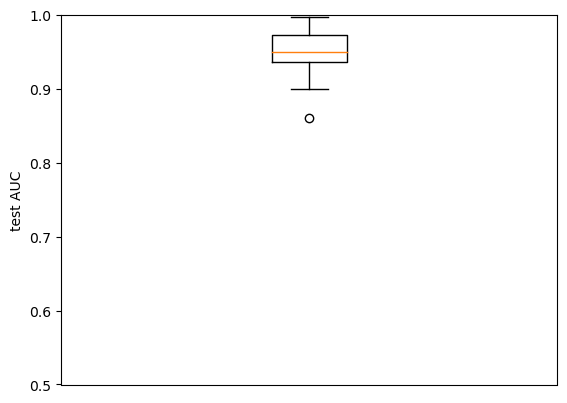

In [41]:
Y_pred = [pk.load(open(TEST_PATH+"/predictions/fold_%i.pk"%i, "rb")) for i in range(kf.get_n_splits())]
Y_true = [Y[test] for _, test in kf.split(X, Y)]
len(Y_pred), len(Y_true)

AUCs = np.array([roc_auc_score(t, y) for t, y in zip(Y_true, Y_pred)])
plt.boxplot(AUCs)
plt.ylim(.5,1)
plt.xticks([])
plt.ylabel("test AUC")
plt.show()

#### Once the significance level (alpha) has been set, compute and show the mean AUC and its confidence interval

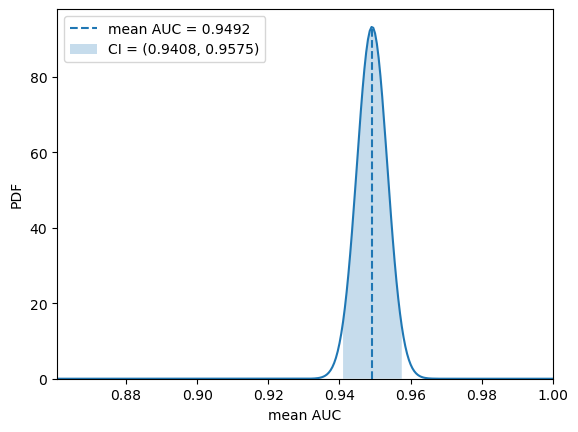

In [42]:
#@markdown Significance level:

alpha=0.95 #@param {type:"slider", min:0.5, max:0.995, step:0.005}

AUC_mean_distribution = stats.norm(loc=AUCs.mean(), scale=AUCs.std(ddof=1)/np.sqrt(len(Y_pred)))
CI = AUC_mean_distribution.interval(alpha)
_bins = np.linspace(.5,1, 1001)
plt.plot(_bins, AUC_mean_distribution.pdf(_bins))
plt.vlines(
  AUCs.mean(), 0, AUC_mean_distribution.pdf(AUCs.mean()),
  linestyle="--", label="mean AUC = %.4f"%AUCs.mean()
)
plt.fill_between(
  _bins[(_bins>CI[0])&(_bins<CI[1])],
  AUC_mean_distribution.pdf(_bins[(_bins>CI[0])&(_bins<CI[1])]),
  alpha=.25, label="CI = (%.4f, %.4f)"%(CI[0], CI[1])
)
plt.xlim(AUCs.min(), 1)
plt.xlabel("mean AUC")
plt.ylabel("PDF")
plt.ylim(0,None)

plt.legend()
plt.show()

## Performance comparison with other meta-predictors

In [43]:
external_predictors = ["Meta-SNP_score","CAROL_score","Condel_score","COVEC_WMV_score","MtoolBox_DS","APOGEE_score"]
thresholds = np.array([.5, .98, .5, 0, .43, .5])
len(external_predictors), len(thresholds)

extarnal_tools_predictions = mitimpact.loc[Y.index, external_predictors].replace(".", np.nan).astype(float)
extarnal_tools_predictions["Condel_score"] = -extarnal_tools_predictions["Condel_score"]

extarnal_tools_predictions.head()

,Meta-SNP_score,CAROL_score,Condel_score,COVEC_WMV_score,MtoolBox_DS,APOGEE_score
MitImpact_ID,,,,,,
MI.10759,0.32,1.00,-0.01,4.0,0.76,0.71
MI.10766,0.14,0.01,-1.00,-6.0,0.09,0.32
MI.10778,0.09,0.49,-0.76,-6.0,0.08,0.36
MI.10783,0.62,1.00,-0.10,1.0,0.76,0.45
MI.10796,0.31,0.65,-0.48,-3.0,0.38,0.42


#### Compare the mean ROC curves of APOGEE2 vs. other meta-predictors

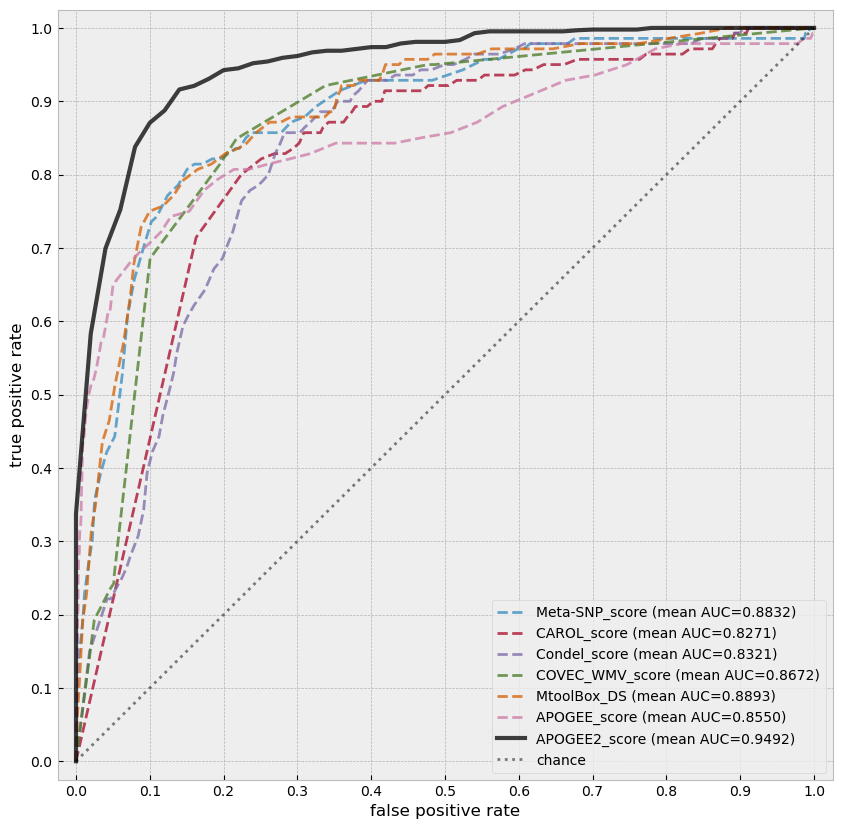

In [44]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,10))

    fpr_bins = np.linspace(0,1,51)

    for predictor in external_predictors:
      fpr, tpr, _ = roc_curve(Y[~extarnal_tools_predictions[predictor].isna()], extarnal_tools_predictions[predictor].dropna())
      plt.plot(
        [0]+list(fpr), [0]+list(tpr),
        linewidth=2, alpha=.75, linestyle="--",
        label="%s (mean AUC=%.4f)"%(predictor, roc_auc_score(Y[~extarnal_tools_predictions[predictor].isna()], extarnal_tools_predictions[predictor].dropna()))
      )
    

    pr_bins = np.linspace(0,1,51)

    tprs = []
    for y_true, y_pred in zip(Y_true, Y_pred): 
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        tprs.append(np.interp(fpr_bins, fpr, tpr))
    tprs = np.array(tprs)
    plt.plot(
        [0]+list(fpr_bins), [0]+list(tprs.mean(0)),
        linewidth=3, alpha=.75, color="k",
        label="APOGEE2_score (mean AUC=%.4f)"%(AUCs.mean()))
    
    plt.plot([0,1], [0,1], "k:", alpha=.5, label="chance")

    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.legend(loc="lower right")
    plt.ylim(-.025,1.025)
    plt.xlim(-.025,1.025)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend()
    plt.show()

# Print system and required packages information

In [2]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,scipy

# date
print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.1
matplotlib: 3.6.2
sklearn   : 1.0.2
scipy     : 1.9.3

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit

 
Last updated: Fri Nov 11 2022 16:48:33W. Europe Standard Time

